In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cust=pd.read_csv('olist_customers_dataset.csv')
orders=pd.read_csv('olist_orders_dataset.csv')
payments=pd.read_csv('olist_order_payments_dataset.csv')

In [3]:
payments=payments.groupby('order_id').agg({'payment_value':'sum'})

In [4]:
ord_pay=pd.merge(payments,orders,on='order_id',how='inner')

In [5]:
df=pd.merge(ord_pay,cust,on='customer_id',how='inner')

In [6]:
cond = df["order_status"] == "delivered"
df = df.loc[cond]

In [7]:
df.shape

(96477, 13)

In [8]:
df["order_purchase_date"] = df["order_purchase_timestamp"].str.slice(0, 10)

df["order_purchase_date"] = pd.to_datetime(df["order_purchase_date"], format="%Y-%m-%d")

In [9]:
df["order_purchase_date"]=df["order_purchase_date"].astype('datetime64[ns]')

In [10]:
df["today"] = df["order_purchase_date"].max()

df["today"] = df["today"].dt.date
df["today"] = pd.to_datetime(df["today"], format="%Y-%m-%d")

In [11]:
df["order_purchase_days_since"] = df["today"]  - df["order_purchase_date"]
df["order_purchase_days_since"] = df["order_purchase_days_since"].astype(str)
df["order_purchase_days_since"] = df["order_purchase_days_since"].str.replace(r'\s+days.*', '', regex=True)
df["order_purchase_days_since"] = df["order_purchase_days_since"].astype(int)
df["order_purchase_year"] = df["order_purchase_date"].dt.year

agg_group = {
    "order_purchase_days_since": ["min", "max", "count"],
    "payment_value": ["sum","mean"]
}

df_group = df.groupby(["customer_unique_id"]).agg(agg_group).reset_index()

df_group.columns = [' '.join(col).strip() for col in df_group.columns.values]

columns_rename = {
    "order_purchase_days_since min": "Recency",
    "order_purchase_days_since max": "last_order_purchase",
    "order_purchase_days_since count": "Frequency",
    "payment_value mean": "payment_value_mean",
    "payment_value sum": "Monetary_Value"
}

df_group.rename(columns_rename, axis=1, inplace=True)



In [12]:
df_group

,customer_unique_id,Recency,last_order_purchase,Frequency,Monetary_Value,payment_value_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,111,111,1,141.90,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,114,1,27.19,27.19
2,0000f46a3911fa3c0805444483337064,537,537,1,86.22,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,321,1,43.62,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,288,1,196.89,196.89
...,...,...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,447,447,1,2067.42,2067.42
93353,fffea47cd6d3cc0a88bd621562a9d061,262,262,1,84.58,84.58
93354,ffff371b4d645b6ecea244b27531430a,568,568,1,112.46,112.46
93355,ffff5962728ec6157033ef9805bacc48,119,119,1,133.69,133.69


In [13]:
df["order_purchase_days_since"].min()

0

In [14]:
rfm=df_group.loc[:,['customer_unique_id','Recency','Frequency','Monetary_Value']]

In [15]:
rfm

,customer_unique_id,Recency,Frequency,Monetary_Value
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89
...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,2067.42
93353,fffea47cd6d3cc0a88bd621562a9d061,262,1,84.58
93354,ffff371b4d645b6ecea244b27531430a,568,1,112.46
93355,ffff5962728ec6157033ef9805bacc48,119,1,133.69


In [16]:
## Applying Paretto

In [17]:
#get the 80% of the revenue
pareto_cutoff = rfm['Monetary_Value'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  12337969.42


In [18]:
customers_rank = rfm
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['Monetary_Value'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()

,customer_unique_id,Recency,Frequency,Monetary_Value,Rank
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,34116.5
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,91330.5
2,0000f46a3911fa3c0805444483337064,537,1,86.22,56530.5
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,81921.5
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,20543.5


In [19]:
customers_rank.sort_values('Rank',ascending=True)

,customer_unique_id,Recency,Frequency,Monetary_Value,Rank
3724,0a0a92112bd4c708ca5fde585afaa872,334,1,13664.08,1.0
79635,da122df9eeddfedc1dc1f5349a1a690c,515,2,7571.63,2.0
43168,763c8b1c9c68a0229c42c9fc6f662b93,45,1,7274.88,3.0
80462,dc4802a71eae9be1dd28f5d788ceb526,563,1,6929.31,4.0
25436,459bef486812aa25204be022145caa62,35,1,6922.21,5.0
...,...,...,...,...,...
14799,2878e5b88167faab17d4fb83a986d38b,304,1,11.63,93353.5
40696,6f5b9d1cdccc4d28f0483a612edecacf,361,1,11.63,93353.5
65458,b33336f46234b24a613ad9064d13106d,69,1,10.89,93355.0
69026,bd06ce0e06ad77a7f681f1a4960a3cc6,350,1,10.07,93356.0


In [20]:
top_20_cutoff = 93357  *20 /100
top_20_cutoff

18671.4

In [21]:
#sum the monetary values over the customer with rank <=773
revenueByTop20 = customers_rank[customers_rank['Rank'] <= top_20_cutoff]['Monetary_Value'].sum()
revenueByTop20

8254039.94

#### In our case, the 80% of total revenue is not achieved by the 20% of TOP customers but approximately, it does, because they are greater than our 20% TOP customers who achieve it. It would be interesting to study this group of customers because they are those who make our most revenue.

In [22]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary_Value,Rank
0.25,114.0,1.0,63.06,23340.0
0.50,218.0,1.0,107.78,46730.0
0.75,346.0,1.0,182.56,70017.5


In [23]:
quantiles.to_dict()

{'Recency': {0.25: 114.0, 0.5: 218.0, 0.75: 346.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary_Value': {0.25: 63.06, 0.5: 107.78, 0.75: 182.56},
 'Rank': {0.25: 23340.0, 0.5: 46730.0, 0.75: 70017.5}}

### Applying RFM score formula¶
### The simplest way to create customers segments from RFM Model is to use Quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. one is the best/highest value, and four is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

In [24]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [25]:
#create rfm segmentation table
rfm_segmentation = rfm
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary_Value'].apply(FMScore, args=('Monetary_Value',quantiles,))

In [26]:
rfm_segmentation

,customer_unique_id,Recency,Frequency,Monetary_Value,Rank,R_Quartile,F_Quartile,M_Quartile
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,34116.5,1,4,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,91330.5,1,4,4
2,0000f46a3911fa3c0805444483337064,537,1,86.22,56530.5,4,4,3
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,81921.5,3,4,4
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,20543.5,3,4,1
...,...,...,...,...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,2067.42,165.0,4,4,1
93353,fffea47cd6d3cc0a88bd621562a9d061,262,1,84.58,57420.0,3,4,3
93354,ffff371b4d645b6ecea244b27531430a,568,1,112.46,44913.0,4,4,2
93355,ffff5962728ec6157033ef9805bacc48,119,1,133.69,36965.5,2,4,2


In [27]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,customer_unique_id,Recency,Frequency,Monetary_Value,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,34116.5,1,4,2,142
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,91330.5,1,4,4,144
2,0000f46a3911fa3c0805444483337064,537,1,86.22,56530.5,4,4,3,443
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,81921.5,3,4,4,344
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,20543.5,3,4,1,341


In [28]:
rfm_segmentation[rfm_segmentation['RFMScore']=='111'].sort_values('Monetary_Value', ascending=False)

,customer_unique_id,Recency,Frequency,Monetary_Value,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
73126,c8460e4251689ba205045f3ea17884a1,21,4,4655.91,10.0,1,1,1,111
44955,7b0eaf68a16e4808e5388c67345033c9,102,2,2340.08,98.0,1,1,1,111
52600,906a8a4ec9f3d4c3e64fa6d1c4fe6009,40,2,2020.86,204.0,1,1,1,111
1212,0341bbd5c969923a0f801b9e2d10a7b8,91,2,1999.68,208.0,1,1,1,111
30077,525cda9909aa001ebed396f6e55eae01,22,2,1782.90,287.0,1,1,1,111
...,...,...,...,...,...,...,...,...,...
52872,91352e06066eef42b60b24049ccde4fd,6,2,186.56,22599.0,1,1,1,111
59269,a26fff917d367b218a794da1eecba3fc,62,2,185.94,22730.0,1,1,1,111
74578,cc44d1f72587f44e3af25f68f1db8cd2,51,2,185.64,22810.5,1,1,1,111
71049,c28b1528e093df4b2a5d47f6f2b0d5fb,10,2,185.07,22891.5,1,1,1,111


In [29]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==1]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==1]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='311']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='411']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))

Best Customers:  524
Loyal Customers:  2801
Big Spenders:  23339
Almost Lost:  423
Lost Customers:  337
Lost Cheap Customers:  5957


,customer_unique_id,Recency,Frequency,Monetary_Value,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,34116.5,1,4,2,142
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,91330.5,1,4,4,144
2,0000f46a3911fa3c0805444483337064,537,1,86.22,56530.5,4,4,3,443
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,81921.5,3,4,4,344
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,20543.5,3,4,1,341
...,...,...,...,...,...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,2067.42,165.0,4,4,1,441
93353,fffea47cd6d3cc0a88bd621562a9d061,262,1,84.58,57420.0,3,4,3,343
93354,ffff371b4d645b6ecea244b27531430a,568,1,112.46,44913.0,4,4,2,442
93355,ffff5962728ec6157033ef9805bacc48,119,1,133.69,36965.5,2,4,2,242


In [30]:
deliv=pd.read_csv('delivery_analysis.csv')

In [31]:
deliv.drop('Unnamed: 0',axis=1,inplace=True)

In [32]:
deliv

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,order_delivery_date,...,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,is_same_state,value,product_weight_g,volume,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02,2017-10-10,...,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,yes,38.71,500.0,1976.0,housewares
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,2017-08-15,2017-08-18,...,SP,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,yes,37.77,500.0,1976.0,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,2017-08-02,2017-08-07,...,SP,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,yes,37.77,500.0,1976.0,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,2017-10-23,2017-11-07,...,SP,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,No,44.09,500.0,1976.0,housewares
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-24,2018-08-07,...,SP,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,No,141.46,400.0,4693.0,perfumery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111018,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-18 16:42:51,2017-08-23 15:36:29,2017-08-31 00:00:00,2017-08-10,2017-08-23,...,SP,fb9310710003399b031add3e55f34719,3318,sao paulo,SP,yes,374.12,2800.0,14812.0,sports_leisure
111019,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-18 16:42:51,2017-08-23 15:36:29,2017-08-31 00:00:00,2017-08-10,2017-08-23,...,SP,fb9310710003399b031add3e55f34719,3318,sao paulo,SP,yes,730.12,2800.0,14812.0,sports_leisure
111020,cfa78b997e329a5295b4ee6972c02979,a2f7428f0cafbc8e59f20e1444b67315,delivered,2017-12-20 09:52:41,2017-12-20 10:09:52,2017-12-20 20:25:25,2018-01-26 15:45:14,2018-01-18 00:00:00,2017-12-20,2018-01-26,...,SC,a49e8e11e850592fe685ae3c64b40eca,83870,campo do tenente,PR,No,71.04,300.0,1152.0,musical_instruments
111021,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,2017-03-09,2017-03-17,...,SP,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,yes,85.08,1175.0,5148.0,health_beauty


In [33]:
rfm.shape

(93357, 9)

In [34]:
deliv.shape

(111023, 31)

In [35]:
rfm=pd.merge(rfm,deliv,on='customer_unique_id',how='inner')

In [36]:
rfm.shape

(108760, 39)

In [37]:
rfm.isnull().sum()

customer_unique_id                 0
Recency                            0
Frequency                          0
Monetary_Value                     0
Rank                               0
R_Quartile                         0
F_Quartile                         0
M_Quartile                         0
RFMScore                           0
order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                 14
order_delivered_carrier_date      58
order_delivered_customer_date    133
order_estimated_delivery_date      0
order_purchase_date                0
order_delivery_date              133
estimated_date                     0
days_taken                       133
estimated                          0
is_late                            0
product_id                         0
order_qty                          0
seller_id                          0
price                              0
f

In [38]:
rfm.dropna(inplace=True)

In [39]:
rfm.drop_duplicates(inplace=True)

In [41]:
rfm.to_csv('RFM_Analysis.csv')

In [42]:
print("Best Customers: ",len(rfm[rfm['RFMScore']=='111']))
print('Loyal Customers: ',len(rfm[rfm['F_Quartile']==1]))
print("Big Spenders: ",len(rfm[rfm['M_Quartile']==1]))
print('Almost Lost: ', len(rfm[rfm['RFMScore']=='311']))
print('Lost Customers: ',len(rfm[rfm['RFMScore']=='411']))
print('Lost Cheap Customers: ',len(rfm[rfm['RFMScore']=='444']))

Best Customers:  1509
Loyal Customers:  7122
Big Spenders:  32992
Almost Lost:  1123
Lost Customers:  868
Lost Cheap Customers:  5914


In [67]:
rfm

,customer_unique_id,Recency,Frequency,Monetary_Value,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore,order_id,...,seller_zip_code_prefix,seller_state,customer_zip_code_prefix,customer_city,customer_state,is_same_state,value,product_weight_g,volume,product_category_name_english
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,34116.5,1,4,2,142,e22acc9c116caa3f2b7121bbb380d08e,...,13405,SP,7787,cajamar,SP,yes,141.90,1500.0,7616.0,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,91330.5,1,4,4,144,3594e05a005ac4d06a72673270ef9ec9,...,2215,SP,6053,osasco,SP,yes,27.19,375.0,5148.0,health_beauty
2,0000f46a3911fa3c0805444483337064,537,1,86.22,56530.5,4,4,3,443,b33ec3b699337181488304f362a6b734,...,13232,SP,88115,sao jose,SC,No,86.22,1500.0,43750.0,stationery
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,81921.5,3,4,4,344,41272756ecddd9a9ed0180413cc22fb6,...,3569,SP,66812,belem,PA,No,43.62,150.0,1045.0,telephony
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,20543.5,3,4,1,341,d957021f1127559cd947b62533f484f7,...,12327,SP,18040,sorocaba,SP,yes,196.89,6050.0,528.0,telephony
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108755,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,2067.42,165.0,4,4,1,441,725cf8e9c24e679a8a5a32cb92c9ce1e,...,3908,SP,55250,sanharo,PE,No,1148.28,30000.0,251625.0,health_beauty
108756,fffea47cd6d3cc0a88bd621562a9d061,262,1,84.58,57420.0,3,4,3,343,c71b9252fd7b3b263aaa4cb09319a323,...,18500,SP,44054,feira de santana,BA,No,84.58,1720.0,32076.0,baby
108757,ffff371b4d645b6ecea244b27531430a,568,1,112.46,44913.0,4,4,2,442,fdc45e6c7555e6cb3cc0daca2557dbe1,...,30550,MG,78552,sinop,MT,No,112.46,600.0,3315.0,auto
108758,ffff5962728ec6157033ef9805bacc48,119,1,133.69,36965.5,2,4,2,242,94d3ee0bc2a0af9d4fa47a4d63616e8d,...,14050,SP,29460,bom jesus do norte,ES,No,133.69,444.0,4480.0,watches_gifts


In [69]:
rfm_data = rfm_segmentation.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore','Rank'],axis=1)
rfm_data.head()

,customer_unique_id,Recency,Frequency,Monetary_Value
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89


In [70]:
rfm_data.reset_index()

,index,customer_unique_id,Recency,Frequency,Monetary_Value
0,0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
2,2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89
...,...,...,...,...,...
93352,93352,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,2067.42
93353,93353,fffea47cd6d3cc0a88bd621562a9d061,262,1,84.58
93354,93354,ffff371b4d645b6ecea244b27531430a,568,1,112.46
93355,93355,ffff5962728ec6157033ef9805bacc48,119,1,133.69


In [72]:
rfm_data.index=rfm_data.customer_unique_id

In [75]:
rfm_data.drop('customer_unique_id',axis=1,inplace=True)

In [76]:
rfm_data

,Recency,Frequency,Monetary_Value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
0000f46a3911fa3c0805444483337064,537,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
0004aac84e0df4da2b147fca70cf8255,288,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,447,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,262,1,84.58
ffff371b4d645b6ecea244b27531430a,568,1,112.46


In [77]:
rfm_data.corr()

,Recency,Frequency,Monetary_Value
Recency,1.000000,-0.022256,-0.004392
Frequency,-0.022256,1.000000,0.122071
Monetary_Value,-0.004392,0.122071,1.000000


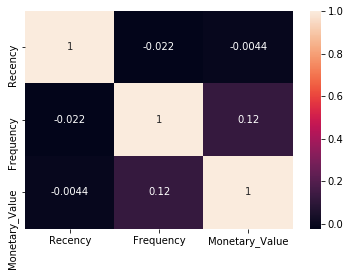

In [78]:
sns.heatmap(rfm_data.corr(), annot=True)

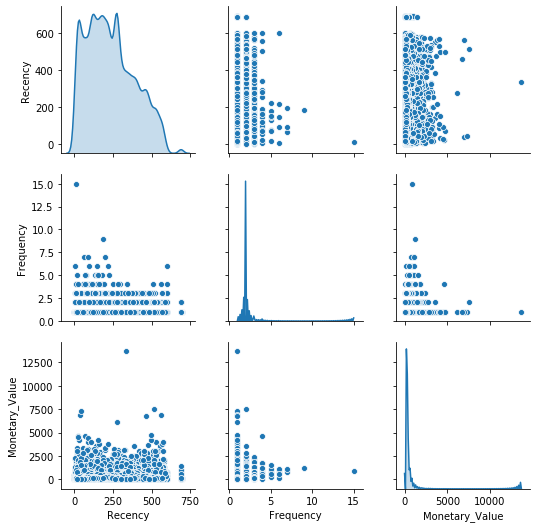

In [79]:
import seaborn as sns
sns.pairplot(rfm_data,diag_kind='kde')

We can notice that we have a **skewed distribution** of the 3 variables and there exist **outliers**.

This indicates how normalization is required to make the data features normally distributed as **clustering** algorithms **require** them to be **normally distributed**.

In [81]:
#log transformation
rfm_r_log = np.log(rfm_data['Recency']+0.1) #can't take log(0) and so add a small number
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary_Value']+0.1)

In [82]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

In [83]:
log_data.head()

,Monetary,Recency,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,4.955827,4.710431,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,3.306520,4.737075,0.0
0000f46a3911fa3c0805444483337064,4.458061,6.286184,0.0
0000f6ccb0745a6a4b88665a16c9f078,3.777806,5.771753,0.0
0004aac84e0df4da2b147fca70cf8255,5.283153,5.663308,0.0


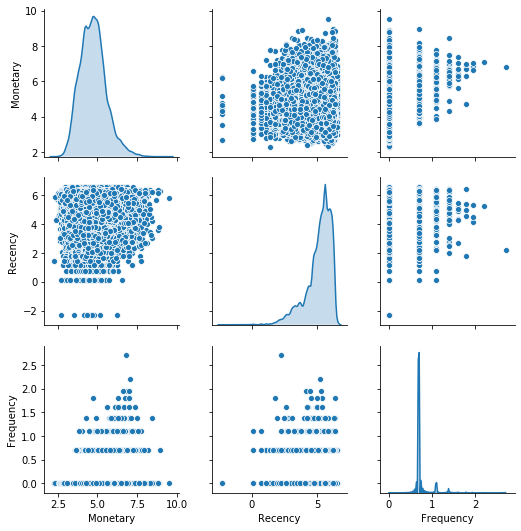

In [84]:
# Produce a scatter matrix for each pair of features in the data
sns.pairplot(log_data,diag_kind='kde');

In [85]:
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.003214,0.164244
Recency,-0.003214,1.000000,-0.016988
Frequency,0.164244,-0.016988,1.000000


## K-Means Implementation

In [87]:
X=log_data

In [88]:
from sklearn.cluster import KMeans
# Let us check optimal number of clusters-
cluster_range = range( 1, 15)
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 100,init='k-means++',random_state=0)
  clusters.fit(X)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia
# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:10]

,num_clusters,cluster_errors
0,1,149496.532704
1,2,92029.886739
2,3,59965.796482
3,4,49282.545056
4,5,40062.950542
5,6,34368.623158
6,7,30200.140067
7,8,27188.978377
8,9,24453.872245
9,10,22542.480557


In [90]:
clusters_df

,num_clusters,cluster_errors
0,1,149496.532704
1,2,92029.886739
2,3,59965.796482
3,4,49282.545056
4,5,40062.950542
5,6,34368.623158
6,7,30200.140067
7,8,27188.978377
8,9,24453.872245
9,10,22542.480557


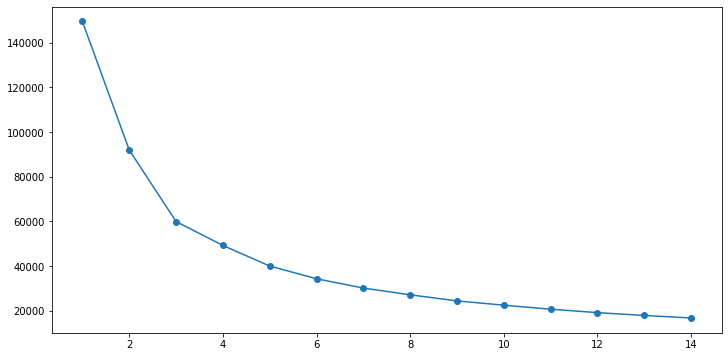

In [89]:
# Elbow plot

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [91]:
# Number of clusters
kmeans = KMeans(n_clusters=5,n_init = 100,init='k-means++',random_state=0)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
# Comparing with scikit-learn centroids
print("Centroid values")
print("sklearn")
print(centroids) # From sci-kit learn

Centroid values
sklearn
[[4.97050392e+00 5.78160231e+00 2.34797720e-02]
 [3.88446763e+00 5.65654152e+00 2.72894389e-03]
 [6.13201364e+00 5.29068638e+00 6.99059776e-02]
 [4.68009219e+00 3.05220245e+00 2.39695294e-02]
 [4.59613816e+00 4.63537406e+00 1.50148640e-02]]


In [92]:
colnames = ["Monetary", "Recency","Frequency"]
prediction= kmeans.predict(X)
#X["clusters"] = prediction
X_df = pd.DataFrame(X, columns= colnames)
X_df["group"] = prediction

In [93]:
X_df

,Monetary,Recency,Frequency,group
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,4.955827,4.710431,0.0,4
0000b849f77a49e4a4ce2b2a4ca5be3f,3.306520,4.737075,0.0,1
0000f46a3911fa3c0805444483337064,4.458061,6.286184,0.0,0
0000f6ccb0745a6a4b88665a16c9f078,3.777806,5.771753,0.0,1
0004aac84e0df4da2b147fca70cf8255,5.283153,5.663308,0.0,0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,7.634105,6.102782,0.0,2
fffea47cd6d3cc0a88bd621562a9d061,4.438879,5.568726,0.0,1
ffff371b4d645b6ecea244b27531430a,4.723486,6.342297,0.0,0


C:\Users\Mathi Azhakan C R\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Mathi Azhakan C R\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


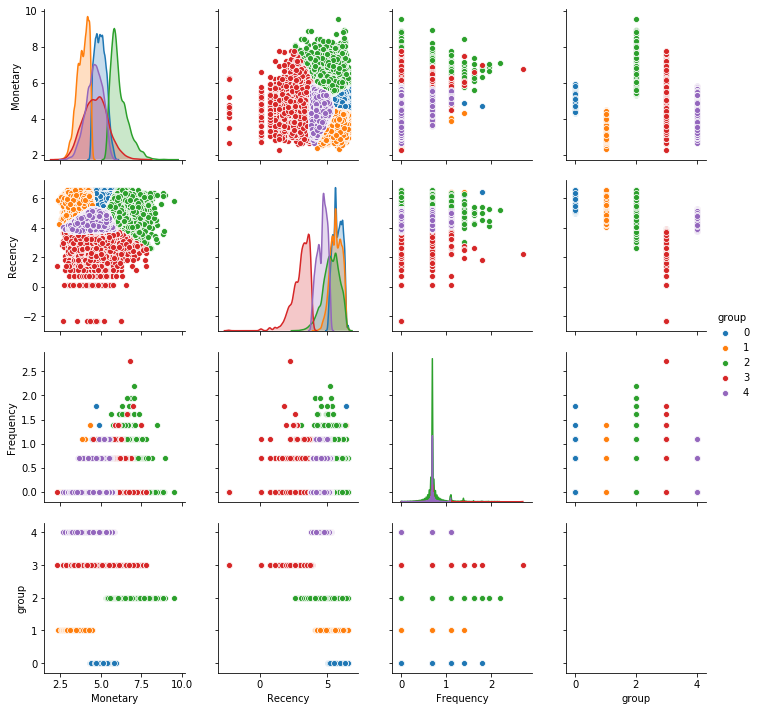

In [94]:
sns.pairplot(X_df,diag_kind='kde',hue='group')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002339B57DF48>,
      dtype=object)

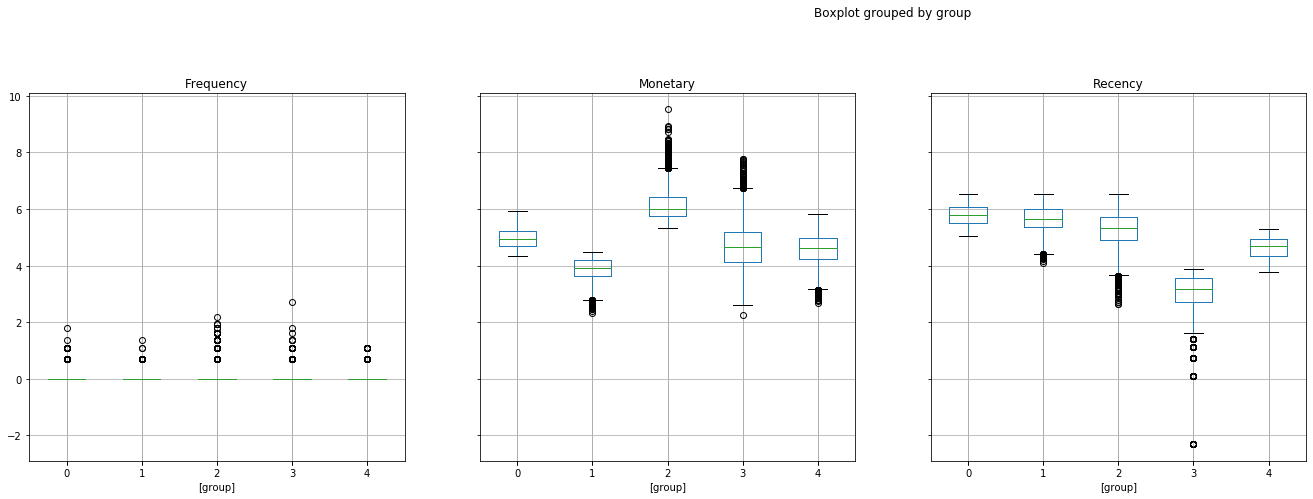

In [95]:
X_df.boxplot(by = 'group',layout=(2,4), figsize=(30, 15))

In [ ]:
#0-lost valuble customers
#1-Low spending Lost customers
#2-High Spending customers
#3-Best customers
#4-Loyal customers


In [100]:
#Lets Map them Accordingly
mapper={0:'Lost Valuble Customer',1:'Low spending Lost Customers',2:'High spending customers',3:'Best customers',4:'Loyal customers'}

In [101]:
X_df.group=X_df.group.map(mapper)

In [105]:
X_df.sort_values(by='Frequency', ascending=False)

,Monetary,Recency,Frequency,group
customer_unique_id,,,,
8d50f5eadf50201ccdcedfb9e2ac8455,6.779206,2.208274,2.708050,Best customers
3e43e6105506432c953e165fb2acf44c,7.067115,5.210032,2.197225,High spending customers
1b6c7548a2a1f9037c1fd3ddfed95f33,6.866006,5.278625,1.945910,High spending customers
ca77025e7201e3b30c44b472ff346268,7.023599,4.489759,1.945910,High spending customers
6469f99c1f9dfae7733b25662e7f1782,6.631910,4.128746,1.945910,High spending customers
...,...,...,...,...
565811ed44e539a14bc391cf57373ed1,3.432050,5.617135,0.000000,Low spending Lost Customers
5657f9f721c16800a66c21081d46b18d,4.186772,5.645800,0.000000,Low spending Lost Customers
5657dfebff5868c4dc7e8355fea865c4,4.658521,5.673667,0.000000,Lost Valuble Customer
